In this notebook we try to predict fumigation status using the microbiome data.

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We first try group into family level and use xgboost to predict fumigation status.

In [3]:
# read in data
df_abundance = pd.read_csv('bac_abundance.csv')
metadata = pd.read_csv("samp_metadata.csv")

In [4]:
df_abundance.drop(columns=['Unnamed: 0'], inplace=True)
df_family = df_abundance.groupby('Family').sum()
df_family.head()

C:\Users\tiany\AppData\Local\Temp\ipykernel_26024\2874980339.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_family = df_abundance.groupby('Family').sum()


,Samp001,Samp002,Samp003,Samp004,Samp005,Samp006,Samp007,Samp008,Samp009,Samp010,...,Samp231,Samp232,Samp233,Samp234,Samp235,Samp236,Samp237,Samp238,Samp239,Samp240
Family,,,,,,,,,,,,,,,,,,,,,
01D2Z36,1,0,0,0,0,0,0,0,2,0,...,17,1,6,3,4,7,4,5,1,5
0319-6G20,4,0,4,5,4,0,10,3,3,8,...,15,10,19,8,20,30,18,16,28,27
053A03-B-DI-P58,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
27F-1492R,0,0,1,0,0,0,1,1,0,0,...,0,0,0,3,1,6,1,1,3,1
37-13,4,0,3,2,0,2,6,3,0,7,...,15,8,20,8,9,20,6,28,11,15


In [5]:
metadata.drop(columns=['Unnamed: 0'], inplace=True)
metadata.head()

,Samp,samp_number,Time,Treatment,Date
0,Fum-1-1,1,Day_0,Non-amended,2016-08-08
1,Fum-1-2,2,Day_0,Non-amended,2016-08-08
2,Fum-1-3,3,Day_0,Non-amended,2016-08-08
3,Fum-1-4,4,Day_0,Non-amended,2016-08-08
4,Fum-1-5,5,Day_0,Non-amended,2016-08-08


In [6]:
# 0 = non-fumigated, 1 = recently fumigated, 2 = fumigated more than a month ago
metadata["Fumigation"] = None

for i, row in enumerate(metadata.itertuples()):
    if row.Time == "Day_0" or row.Treatment == "Non-fumigated chipping grass":
        metadata.at[i, "Fumigation"] = 0
    elif row.Time == "Day_10" and row.Treatment != "Non-fumigated chipping grass":
        metadata.at[i, "Fumigation"] = 1
    else:
        metadata.at[i, "Fumigation"] = 2

metadata


,Samp,samp_number,Time,Treatment,Date,Fumigation
0,Fum-1-1,1,Day_0,Non-amended,2016-08-08,0
1,Fum-1-2,2,Day_0,Non-amended,2016-08-08,0
2,Fum-1-3,3,Day_0,Non-amended,2016-08-08,0
3,Fum-1-4,4,Day_0,Non-amended,2016-08-08,0
4,Fum-1-5,5,Day_0,Non-amended,2016-08-08,0
...,...,...,...,...,...,...
235,Fum-1-236,236,Day_282,Non-fumigated chipping grass,2017-05-17,0
236,Fum-1-237,237,Day_282,Non-fumigated chipping grass,2017-05-17,0
237,Fum-1-238,238,Day_282,Non-fumigated chipping grass,2017-05-17,0
238,Fum-1-239,239,Day_282,Non-fumigated chipping grass,2017-05-17,0


In [7]:
# Get X and y
X = df_family.T.values
y = metadata["Fumigation"].values.astype(int)

In [8]:
# import more libraries
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from xgboost import XGBClassifier

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create model
model_XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_XGB, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.p

Cross-validated Accuracy: 0.99 (+/- 0.04)


In [9]:
# test model
model_XGB.fit(X_train, y_train)
y_pred = model_XGB.predict(X_test)
test_score = model_XGB.score(X_test, y_test)
print("Test Accuracy: %0.2f" % test_score)

Test Accuracy: 0.96


Now, we try using random forest to predict fumigation status.

In [10]:
# random forest
from sklearn.ensemble import RandomForestClassifier

# create model
model_RF = RandomForestClassifier(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_RF, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 1.00 (+/- 0.03)


In [11]:
# test model
model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_test)
test_score = model_RF.score(X_test, y_test)
print("Test Accuracy: %0.2f" % test_score)

Test Accuracy: 0.96


Use logistic regression to predict fumigation status.

In [12]:
# normalize data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# create model
model_logreg = LogisticRegression(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_logreg, X_train_scaled, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 1.00 (+/- 0.02)


In [14]:
# test model
model_logreg.fit(X_train_scaled, y_train)
y_pred = model_logreg.predict(X_test_scaled)
test_score = model_logreg.score(X_test_scaled, y_test)

print("Test Accuracy: %0.2f" % test_score)

Test Accuracy: 0.98


In [15]:
# find important features
coefficients = model_logreg.coef_[0]
feature_names = list(df_family.T.columns)

# sort features by importance
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

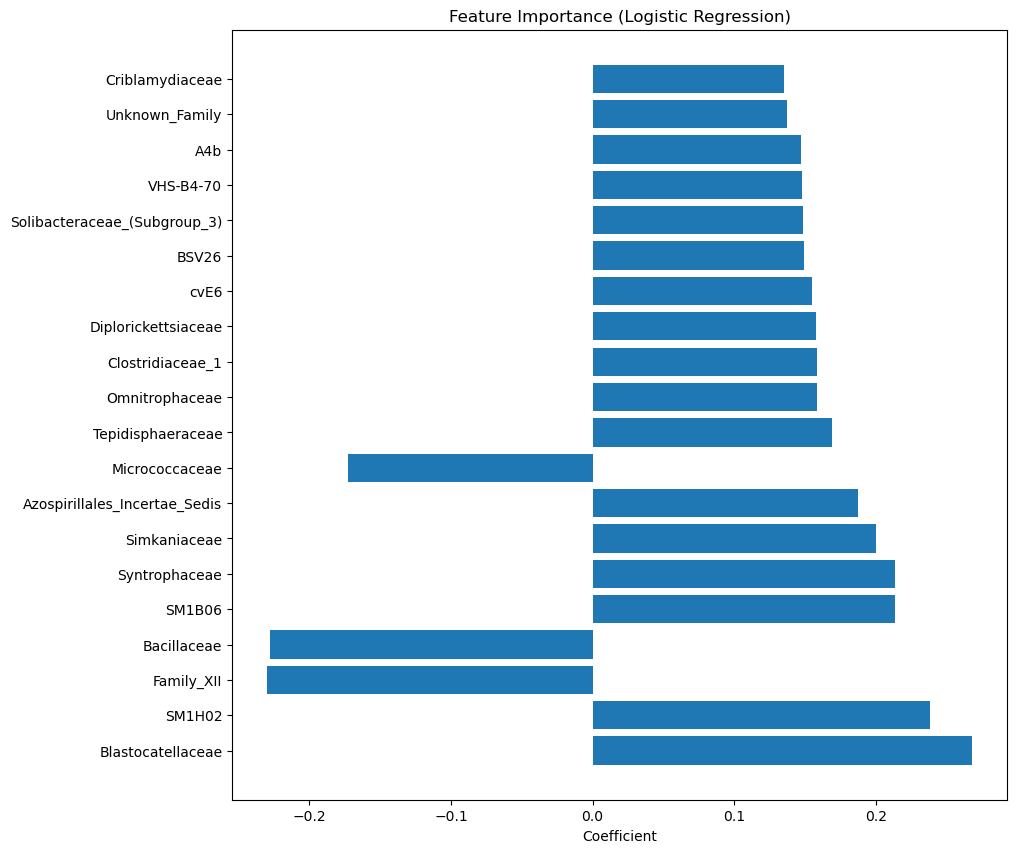

In [16]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_coefficients[:20])
plt.xlabel("Coefficient")
plt.title("Feature Importance (Logistic Regression)")
plt.show()

In [17]:
# print the 20 most important features
print("Most important features: ")

for i in range(20):
    print(sorted_features[i], sorted_coefficients[i])

logreg_top20_feature = sorted_features[:20]

Most important features: 
Blastocatellaceae 0.26765347969778264
SM1H02 0.23818741115409794
Family_XII -0.22955180198587555
Bacillaceae -0.22740166463102726
SM1B06 0.2134237071981502
Syntrophaceae 0.21321580191356676
Simkaniaceae 0.20025986935931178
Azospirillales_Incertae_Sedis 0.18730403242804658
Micrococcaceae -0.1724807680719207
Tepidisphaeraceae 0.1690140177308218
Omnitrophaceae 0.15848248068490567
Clostridiaceae_1 0.15831728775312442
Diplorickettsiaceae 0.15795962499126437
cvE6 0.15494391100727667
BSV26 0.1492608811241141
Solibacteraceae_(Subgroup_3) 0.148186270179523
VHS-B4-70 0.1474360907933724
A4b 0.1467894832348996
Unknown_Family 0.13748583153440444
Criblamydiaceae 0.13521831137882206


Now we determine the most important features using random forest.

In [18]:
importances = model_RF.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

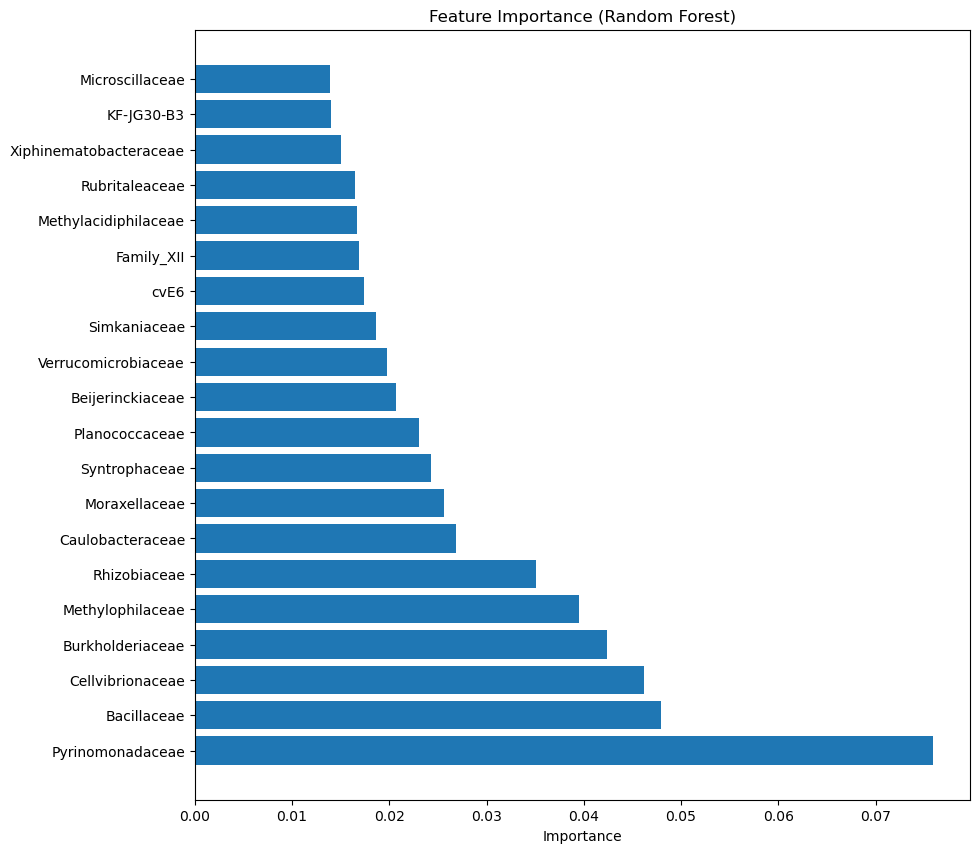

In [19]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [20]:
# print the 20 most important features
print("Most important features predicted by Random Forest Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

RF_top20_feature = sorted_features[:20]

Most important features predicted by Random Forest Classifier: 
Pyrinomonadaceae 0.07588058132501259
Bacillaceae 0.04792124711666407
Cellvibrionaceae 0.04621525377026519
Burkholderiaceae 0.042339376398030246
Methylophilaceae 0.039471872391412394
Rhizobiaceae 0.03508663826741006
Caulobacteraceae 0.026851773762488852
Moraxellaceae 0.025584962907471025
Syntrophaceae 0.024326661908955875
Planococcaceae 0.023015919037566526
Beijerinckiaceae 0.020721462675147902
Verrucomicrobiaceae 0.0197200270953373
Simkaniaceae 0.01859893918000779
cvE6 0.017451826818745447
Family_XII 0.016915042413390837
Methylacidiphilaceae 0.01665227545587012
Rubritaleaceae 0.016472792344267566
Xiphinematobacteraceae 0.015054935865010869
KF-JG30-B3 0.014047015385083165
Microscillaceae 0.013919038603001421


Now we find the most important features using XGBoost.

In [21]:
# find important features
importances = model_XGB.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

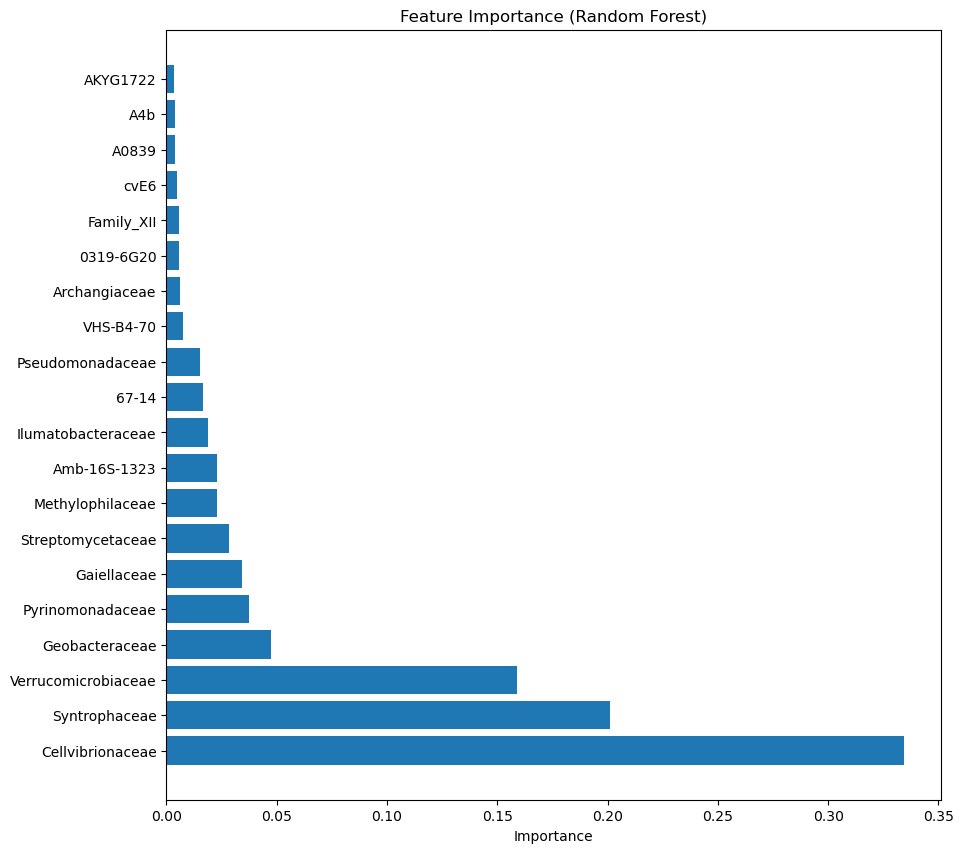

In [22]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [23]:
# print the 20 most important features
print("Most important features predicted by XGBoost Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

XGB_top20_feature = sorted_features[:20]

Most important features predicted by XGBoost Classifier: 
Cellvibrionaceae 0.33459222
Syntrophaceae 0.20109332
Verrucomicrobiaceae 0.15889469
Geobacteraceae 0.047368817
Pyrinomonadaceae 0.037626486
Gaiellaceae 0.03448997
Streptomycetaceae 0.028192846
Methylophilaceae 0.023060888
Amb-16S-1323 0.022947285
Ilumatobacteraceae 0.018696543
67-14 0.016473154
Pseudomonadaceae 0.015174222
VHS-B4-70 0.0074074348
Archangiaceae 0.0061832727
0319-6G20 0.005793729
Family_XII 0.0055880384
cvE6 0.004866665
A0839 0.003839388
A4b 0.0037455999
AKYG1722 0.0036635592


In [24]:
# find common features
common_features = []
for feature in logreg_top20_feature:
    if feature in RF_top20_feature and feature in XGB_top20_feature:
        common_features.append(feature)

print("Common features: ", common_features)

Common features:  ['Family_XII', 'Syntrophaceae', 'cvE6']


It can be seen that the most important features are different for random forest and XGBoost and logistic regression.

## Genus Level

Now we group the data into genus level. We see the model performance and the most important features.

In [26]:
## create genus level data
df_genus = df_abundance.groupby('Genus').sum()
len(df_genus)

C:\Users\tiany\AppData\Local\Temp\ipykernel_26024\1138614204.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_genus = df_abundance.groupby('Genus').sum()


690

In [27]:
# Get X and y
X = df_genus.T.values
y = metadata["Fumigation"].values.astype(int)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check how many data enries we have
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (192, 690)
Shape of X_test:  (48, 690)
Shape of y_train:  (192,)
Shape of y_test:  (48,)


In [28]:
# create model
model_XGB = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_XGB, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tiany\anaconda3\Lib\site-packages\xgboost\sklearn.p

Cross-validated Accuracy: 0.98 (+/- 0.04)


In [29]:
# test model
model_XGB.fit(X_train, y_train)
y_pred = model_XGB.predict(X_test)

test_score = model_XGB.score(X_test, y_test)

print("Test Accuracy: %0.2f" % test_score)

Test Accuracy: 0.98


In [30]:
# create model
model_RF = RandomForestClassifier(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)
scores = cross_val_score(model_RF, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 0.99 (+/- 0.03)


In [31]:
# test model
model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_test)

test_score = model_RF.score(X_test, y_test)

print("Test Accuracy: %0.2f" % test_score)

Test Accuracy: 0.98


In [32]:
# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create model
model_logreg = LogisticRegression(random_state=42)

# cv
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=40, random_state=42)

scores = cross_val_score(model_logreg, X_train_scaled, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

# Print the mean and standard deviation of the scores 
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross-validated Accuracy: 0.99 (+/- 0.03)


In [33]:
# test model
model_logreg.fit(X_train_scaled, y_train)
y_pred = model_logreg.predict(X_test_scaled)

test_score = model_logreg.score(X_test_scaled, y_test)

print("Test Accuracy: %0.2f" % test_score)

Test Accuracy: 0.98


In [34]:
# find important features
coefficients = model_logreg.coef_[0]
feature_names = list(df_genus.T.columns)

# sort features by importance
sorted_idx = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_coefficients = coefficients[sorted_idx]

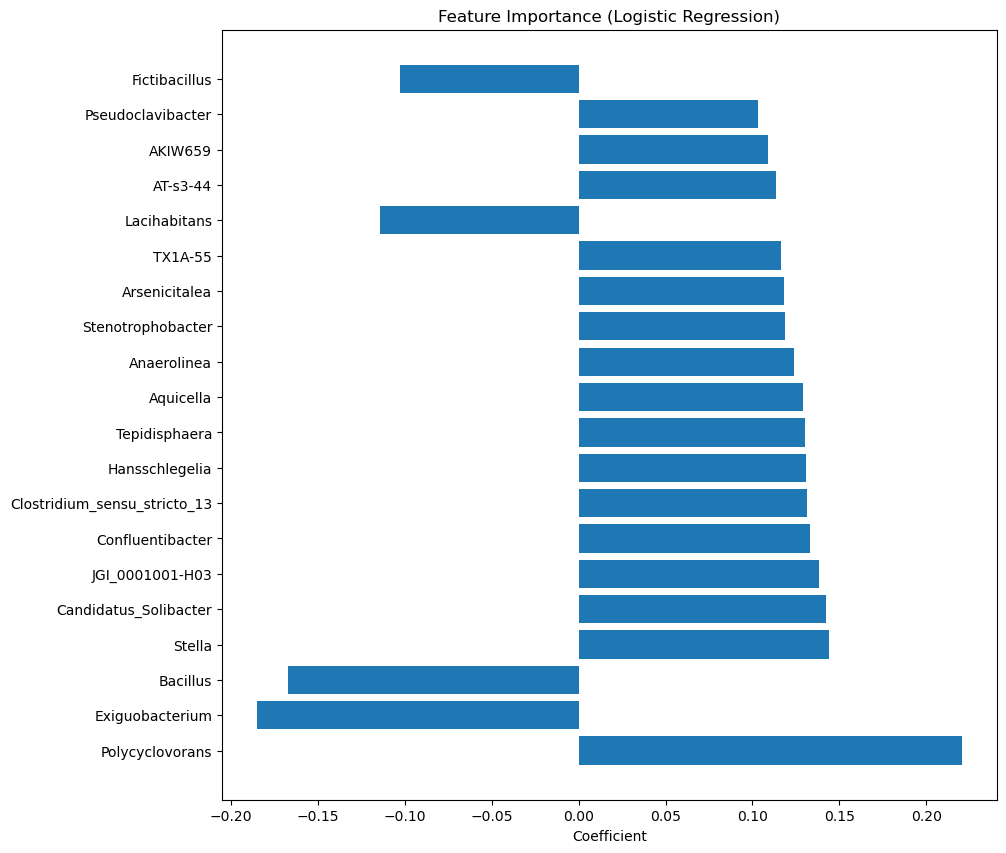

In [35]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_coefficients[:20])
plt.xlabel("Coefficient")
plt.title("Feature Importance (Logistic Regression)")
plt.show()

In [36]:
# print the 20 most important features
print("Most important features: ")

for i in range(20):
    print(sorted_features[i], sorted_coefficients[i])

logreg_top20_feature = sorted_features[:20]

Most important features: 
Polycyclovorans 0.22046714632085782
Exiguobacterium -0.18501644478679632
Bacillus -0.16731291920262098
Stella 0.14396358914739588
Candidatus_Solibacter 0.14223865710537245
JGI_0001001-H03 0.13832932718633054
Confluentibacter 0.1331516769955963
Clostridium_sensu_stricto_13 0.13112385381002784
Hansschlegelia 0.13087091080586974
Tepidisphaera 0.13048696440522398
Aquicella 0.12894682931353982
Anaerolinea 0.1240117545919301
Stenotrophobacter 0.1189125423120824
Arsenicitalea 0.11839719439692499
TX1A-55 0.11642564635881605
Lacihabitans -0.1145588182721946
AT-s3-44 0.11377897459217944
AKIW659 0.1086743497875021
Pseudoclavibacter 0.1033097508374719
Fictibacillus -0.10279121574793398


In [37]:
# find important features
importances = model_RF.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

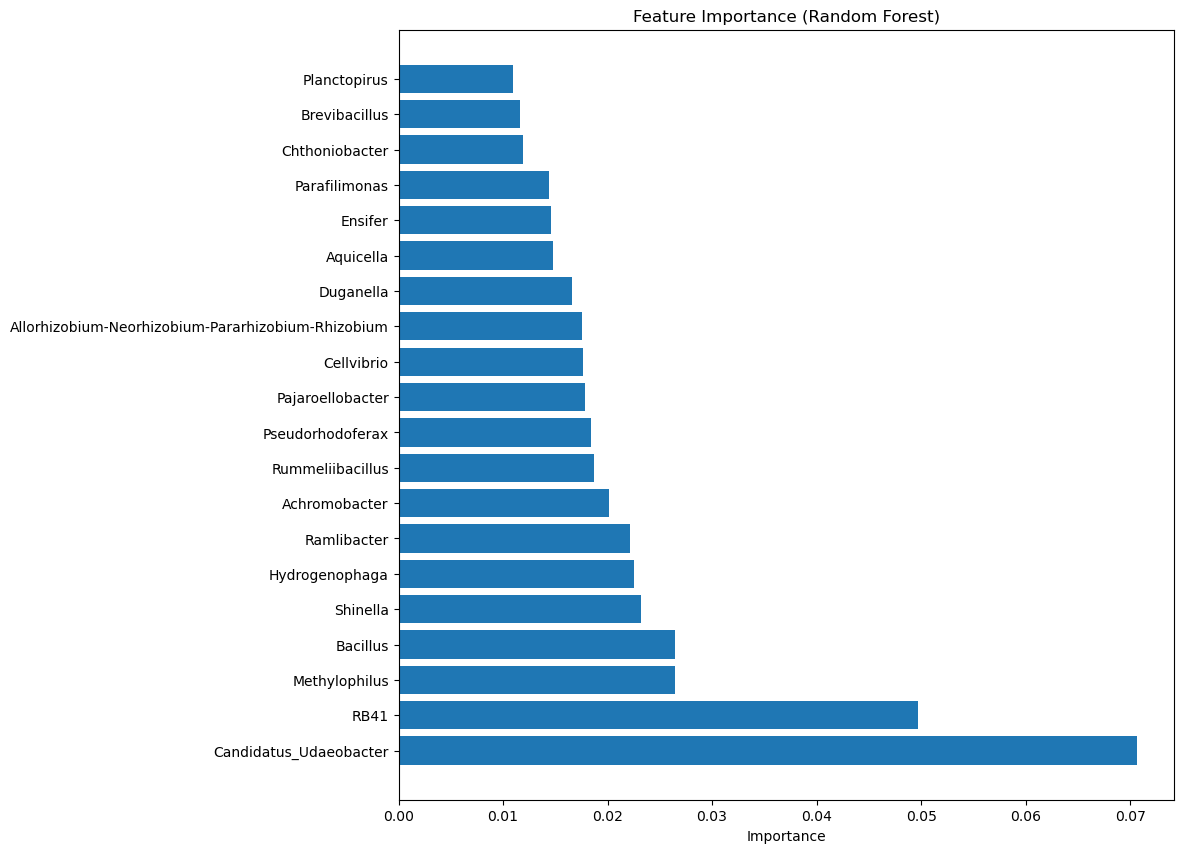

In [38]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()

In [39]:
# print the 20 most important features
print("Most important features predicted by Random Forest Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

RF_top20_feature = sorted_features[:20]

Most important features predicted by Random Forest Classifier: 
Candidatus_Udaeobacter 0.07062682685763119
RB41 0.0497071179812262
Methylophilus 0.026463301108033566
Bacillus 0.02640419229684137
Shinella 0.023197296530762447
Hydrogenophaga 0.02253111690278967
Ramlibacter 0.02217408955832827
Achromobacter 0.02014364574327185
Rummeliibacillus 0.018723010619595453
Pseudorhodoferax 0.01843986331869936
Pajaroellobacter 0.017820093363647357
Cellvibrio 0.017635023068463405
Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium 0.017511267593773493
Duganella 0.016590280752867205
Aquicella 0.014792367335457288
Ensifer 0.014588278843975818
Parafilimonas 0.01435112216814832
Chthoniobacter 0.0119376691059551
Brevibacillus 0.011580695491287174
Planctopirus 0.010972588483419697


In [40]:
# find important features
importances = model_XGB.feature_importances_
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[idx] for idx in sorted_idx]
sorted_importances = importances[sorted_idx]

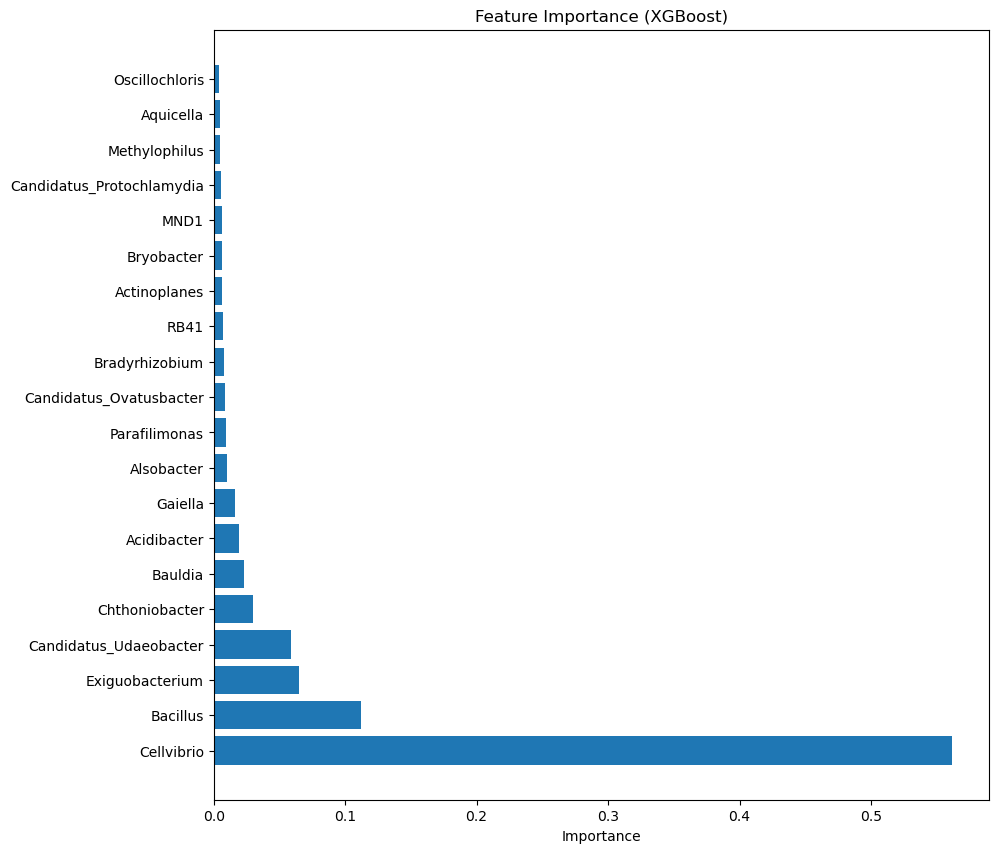

In [43]:
# plot the 20 most important features
plt.figure(figsize=(10, 10))
plt.barh(sorted_features[:20], sorted_importances[:20])
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.show()

In [44]:
# print the 20 most important features
print("Most important features predicted by XGBoost Classifier: ")

for i in range(20):
    print(sorted_features[i], sorted_importances[i])

XGB_top20_feature = sorted_features[:20]

Most important features predicted by XGBoost Classifier: 
Cellvibrio 0.5614678
Bacillus 0.111815885
Exiguobacterium 0.0652117
Candidatus_Udaeobacter 0.058634598
Chthoniobacter 0.029554099
Bauldia 0.023357501
Acidibacter 0.019605272
Gaiella 0.015918527
Alsobacter 0.010386094
Parafilimonas 0.009595161
Candidatus_Ovatusbacter 0.008317264
Bradyrhizobium 0.0074469466
RB41 0.007193579
Actinoplanes 0.0066464497
Bryobacter 0.006433137
MND1 0.0059655868
Candidatus_Protochlamydia 0.0056066466
Methylophilus 0.005109738
Aquicella 0.0047788275
Oscillochloris 0.0039443616


In [45]:
# find common features
common_features = []
for feature in logreg_top20_feature:
    if feature in RF_top20_feature and feature in XGB_top20_feature:
        common_features.append(feature)

print("Common features: ", common_features)

Common features:  ['Bacillus', 'Aquicella']
